<a href="https://colab.research.google.com/github/tsangrebecca/BloomTech/blob/main/Sprint7/Module3/DS_233_guided_project_BaggingVsBoosting_GB_XGBModel_FeatureImportanceWithDifferentTechniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BloomTech Data Science

---

# Permutation & Boosting

- Get **permutation importances** for model interpretation and feature selection
- Use xgboost for **gradient boosting**

# Downloading the Tanzania Waterpump Dataset

Make sure  you only use the dataset that is available through the **DS** **Kaggle Competition**. DO NOT USE any other Tanzania waterpump datasets that you might find online.

There are two ways you can get the dataset. Make sure you have joined the competition first!:

1. You can download the dataset directly by accessing the challenge and the files through the Kaggle Competition URL on Canvas (make sure you have joined the competition!)

2. Use the Kaggle API using the code in the following cells. This article provides helpful information on how to fetch your Kaggle Dataset into Google Colab using the Kaggle API.

> https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a

# Using Kaggle API to download datset

In [ ]:
# mounting your google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#change your working directory, if you want to or have already saved your kaggle dataset on google drive.
%cd /content/gdrive/My Drive/Kaggle
# update it to your folder location on drive that contains the dataset and/or kaggle API token json file.

/content/gdrive/My Drive/Kaggle


In [ ]:
# Download your Kaggle Dataset, if you haven't already done so.
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# !kaggle competitions download -c bloomtech-water-pump-challenge # double check if this command corresponds with the one given in Canvas

In [ ]:
# Unzip your Kaggle dataset, if you haven't already done so.
# !unzip \*.zip  && rm *.zip

In [ ]:
# List all files in your Kaggle folder on your google drive.
!ls

sample_submission.csv  test_features.csv  train_features.csv  train_labels.csv


# Install Libraries

In [ ]:
%%capture
!pip install category_encoders==2.*

In [ ]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# encoders
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer

#pipeline
from sklearn.pipeline import make_pipeline

# Bagged Model
from sklearn.ensemble import RandomForestClassifier

# NEW IMPORTS!!!!
# Boosted Models
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Permutation Importance
from sklearn.inspection import permutation_importance

# for displaying images and html
from IPython.display import Image
from IPython.core.display import HTML

/usr/local/lib/python3.10/dist-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Wrangle Data

We'll go back to Tanzania Waterpumps for this lesson.

Import test_features.csv, train_features.csv and train_labels.csv, 3 files, from Sprint 6 folder.

In [ ]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, parse_dates=['date_recorded'], na_values=[-2e-08, 0]),
                         pd.read_csv(tv_path)).set_index('date_recorded')

    else:
        df = pd.read_csv(fm_path, parse_dates=['date_recorded']).set_index('date_recorded')

    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because of the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year',
                       'gps_height', 'population']
    for col in cols_with_zeros:
        df[col] = df[col].replace(0, np.nan)
        df[col+'_MISSING'] = df[col].isnull()

    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    df = df.drop(columns=duplicates)

    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    df = df.drop(columns=unusable_variance)

    # Extract components from date_recorded
    df['year_recorded'] = df.index.year
    df['month_recorded'] = df.index.month
    df['day_recorded'] = df.index.day

    # Engineer feature: how many years from construction_year to date_recorded
    df['pump_age'] = df['year_recorded'] - df['construction_year']
    df['years_MISSING'] = df['pump_age'].isnull()

    # return the wrangled dataframe
    return df

In [ ]:
fm_path = 'train_features.csv'
tv_path = 'train_labels.csv'

df = wrangle(fm_path, tv_path)

In [ ]:
# Split data into feature and target
target = 'status_group'
X, y = df.drop(columns = target), df[target]

In [ ]:
# Split data into train, validation and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=42)

In [ ]:
# Baseline Metric
print('The baseline accuracy is ', y_train.value_counts(normalize=True).max())

The baseline accuracy is  0.5425489938182296


In [ ]:
y_train

date_recorded
2011-07-27             non functional
2013-02-13                 functional
2013-01-19             non functional
2013-09-03             non functional
2011-07-14    functional needs repair
                       ...           
2011-08-03                 functional
2011-07-16                 functional
2011-03-09                 functional
2011-02-20                 functional
2011-03-19                 functional
Name: status_group, Length: 38015, dtype: object

# Build Model

## Bagged model - Random Forest

- A weak model is just a decision tree that works slightly beter than the baseline accuracy.
- Random forest is one of the ensembling technique using bagging, we have other techniques like boosting
  - Bootstrap - sampling with replacement
  - Bagging - collective voting or bootstrap aggregation, a type of non-sequential learning method
  - it goes through bootstrap sampling, building the trees on a random set of features, aggregating the results.
  - In a classification model, the majority voting will be the final result.
  - In a regression model, the average prediction will be the final result.
  - We build trees parallel to each other, because each tree is independent of each other

In [ ]:
# Random Forest Model

model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=42, n_jobs=-1,n_estimators=75)
)

# Fit on train, score on val
model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source',...
improved spring                4
other                          5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
                                          'data_type': dtype('O'),
                                          'mapping': hand pump             1
communal standpipe    2
improved spring       3
other                 4
cattle trough         5
dam                   6
NaN                  -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=75, n_jobs=-1,
                                        random_state=42))])

## Boosted Model
### Gradient Boosted Model

Boosting
- boosting is different from bootstrapping
- The trees grow sequentially aka model builds trees one after another, improving upon itself after each iteration
- each tree is grown using info from the previously grown trees, we build trees one after the other.
- we build the model on the entire training set, no longer have to take a random subset
- It is a boosting technique that makes use of a gradient descent method when adding trees to the boosted model.
- Sequential modeling:
1. One tree is built, then all the points that were misclassified by the first tree are focused on, and their weight is increased for the next iteration. The algorithm learns from the previous mistakes.
2. Subsequent tree focuses on these misclassified examples, you slowly learn from the previous mistakes
3. Final prediction is nothing but the weighted majority vote or the weighted median in case of regression

In [ ]:
# Gradient Boosted Model
model_gb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    GradientBoostingClassifier(random_state=42, n_estimators=75)
)

model_gb.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source',...
communal standpipe multiple    3
improved spring                4
other                          5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
                                          'data_type': dtype('O'),
                                          'mapping': hand pump             1
communal standpipe    2
improved spring       3
other                 4
cattle trough         5
dam                   6
NaN                  -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(n_estimators=75, random_state=42))])

- some hyperparameters include max_depth, n_estimators aka number of trees, learning rate
- Learning Rate = we can choose how much each tree is gonna contribute toward the learning of the model
- There's a tradeoff between learning rate and number of trees I wanna build.
- Max depth ensures that samples are not memorized and overfitting does not happen.

PROS for using Boosted Models
- Gradient boosted models are more sensitive than random forest in hyperparameter tuning. If we were to take a boosted and a bagged model out of the box, boosted model won't work as well right away, but it can beneift a lot from hyperparameter tuning.

CONS:
- time-consuming, building one tree at a time, also need to remember the results from the previous tree
- focus a lot on misclassified data, imagine if we have a lot of outliers or noise. So, doesn't work well with data with a lot of outliers

### Extreme Gradient Boosted (XGB) Model

- increase speed and performance while having regularization parameters to prevent overfitting
- remember regularization is to shrink the coefficients to bring them to a much lower value such as in Ridge Regression
- some hyperparamters to tune are learning_rate, max_depth, gamma

PROS:
- speed
- lower variance because of the regularization parameter

CONS:
- hard to understand
- complex because a lot of hyperparameters to tune

In [ ]:
y

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 MB 2.7 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.0.2
    Uninstalling xgboost-2.0.2:
      Successfully uninstalled xgboost-2.0.2


In [ ]:
# XGB Model
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(random_state=42, n_estimators=75, n_jobs=-1)
)
# even tho this is a sequential model (not parallel like RF), we still have ability to implement parallelization with n_jobs in some other aspects of training besides sequential building of tree
model_xgb.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:34:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source',...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=75,
                               n_jobs=-1, num_parallel_tree=1,
                               objective='multi:softprob', random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

# Check Metrics

In [ ]:
print('Training Accuracy', model_rf.score(X_train, y_train))
print('Validation Accuracy', model_rf.score(X_val, y_val))
# RF will perform the best out of the box without any tuning

Training Accuracy 0.9999210837827174
Validation Accuracy 0.8041877104377104


In [ ]:
print('Training Accuracy', model_gb.score(X_train, y_train))
print('Validation Accuracy', model_gb.score(X_val, y_val))

Training Accuracy 0.7537287912666053
Validation Accuracy 0.7432659932659933


In [ ]:
print('Training Accuracy', model_xgb.score(X_train, y_train))
print('Validation Accuracy', model_xgb.score(X_val, y_val))

Training Accuracy 0.846902538471656
Validation Accuracy 0.7888257575757576


### Try adjusting these hyperparameters

#### Random Forest
- class_weight (for imbalanced classes)
- max_depth (usually high, can try decreasing)
- n_estimators (too low underfits, too high wastes time)
- min_samples_leaf (increase if overfitting)
- max_features (decrease for more diverse trees)

#### Xgboost
- scale_pos_weight (for imbalanced classes)
- max_depth (usually low, can try increasing)
- n_estimators (too low underfits, too high wastes time/overfits) — Use Early Stopping!
- learning_rate (too low underfits, too high overfits)

For more ideas, see [Notes on Parameter Tuning](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html) and [DART booster](https://xgboost.readthedocs.io/en/latest/tutorials/dart.html).

# Tuning / Communication

- How can we determine or communicate which features are most important to our model when making predictions?

**Option 1:** Grab feature importances from our pipeline


- There is local and there is global feature importance
  - Global feature importances measure the importance of the feature for the entire model
  - Local feature importance measures the importance of the feature for one specific observation or sample

Text(0, 0.5, 'Feature')

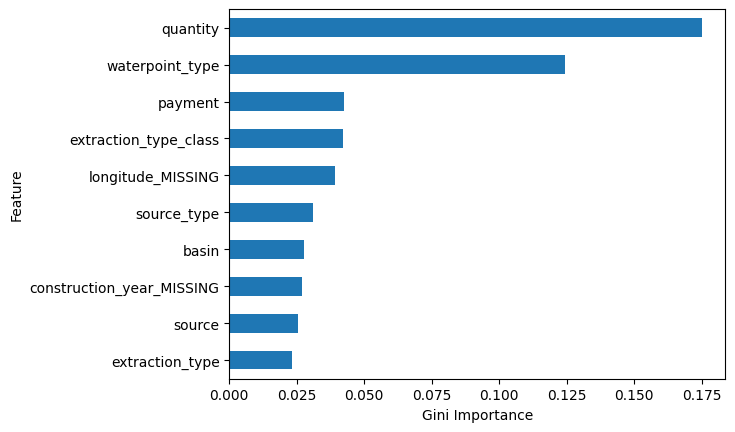

In [ ]:
importances = model_xgb.named_steps['xgbclassifier'].feature_importances_
feature_names = X_train.columns
feat_imp = pd.Series(data=importances, index=feature_names).sort_values()

feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance') # Gini is the probability of misclassifying data
                              # the more the impurity decreases, the more important that feature towards the predictions
plt.ylabel('Feature')

# the plot shows that x-axis with Gini importance and y-axis with features. The most important feature quantity.
# problem of misleading info esp. if I have high cardinality, inflate importance, or when we have correlated features
# quick and easy but not the best one

**Option 2:** Drop-column Importance


- use the process of elimination and re-training
- we take one feature and remove it, and check the accuracy again. If the accuracy drops then that means it's important
- time-consuming, have to re-train the model

In [ ]:
selected_column = 'quantity'

In [ ]:
# XGB model with everything, don't need to re-run
model_with_col = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=75,
                  random_state=42,
                  n_jobs=-1,)
)

model_with_col.fit(X_train, y_train)

print(f'Validation Accuracy w/ "{selected_column}" included:', model_with_col.score(X_val, y_val))

# validation accuracy with the quantity column included is 0.7377

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:37:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Validation Accuracy w/ "quantity" included: 0.7888257575757576


In [ ]:
# XGB model except one selected column, need to re-train model every time when we select a new column to test
model_without_col = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=75,
                  random_state=42,
                  n_jobs=-1,)
)

model_without_col.fit(X_train.drop(columns=selected_column), y_train)


print(f'Validation Accuracy w/ "{selected_column}" excluded:', model_without_col.score(X_val.drop(columns=selected_column), y_val))

# validation accuracy with quantity column excluded is 0.7057
# it has dropped when quantity column is missing, that means quantity is important in the model

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:37:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Validation Accuracy w/ "quantity" excluded: 0.757260101010101


**Option 3:** Permutation Importance

![](https://i.imgur.com/h17tMUU.png)

- very similar to drop column importance method but takes much less time
- train the model with all the features, then select one feature to measure the importance, then measure the performance of my validation set with the selected feature shuffled
- rearrangement in a random process, if accuracy drops by a lot after shuffling, that means the feature is important
- we corrupt the X_val column and then we test it, so it's less intensive
- PROS: we don't have to re-train the model many times.

1. We can do it by hand

In [ ]:
# By hand

# Step 1: Choose my feature
column_to_permute = 'quantity'

# Step 2: Train model w/ ALL features
model_to_permute = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=75,
                  random_state=42,
                  n_jobs=-1,)
)

model_to_permute.fit(X_train, y_train);

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:38:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
# Step 3: Evaluate model using VALIDATION DATA.
print('Validation Accuracy', model_to_permute.score(X_val, y_val))

# validation accuracy is 0.7377

Validation Accuracy 0.7888257575757576


In [ ]:
# Step 4: In VALIDATION DATA, permute the feature we're evaluating
X_val_perm = X_val.copy() # make a copy before shuffling the data
X_val_perm[column_to_permute] = np.random.permutation(X_val_perm[column_to_permute]) # save as a new column
# it's a random process so every run will give a diff permutation

In [ ]:
# Step 5: Calculate our error metric with the permuted data
print('Validation Accuracy', model_to_permute.score(X_val_perm, y_val)) # remember the permutated data, not the original X_val
# we got accuracy score of 0.6443
# accuracy decreases, which means quantity column is important feature to consider

Validation Accuracy 0.688973063973064


2. Or we can get it automated with sklearn

In [ ]:
# Automated using sklearn

perm_imp = permutation_importance(model_to_permute, X_val, y_val, random_state=42)
# it will return a dictionary, takes time to calculate because it needs to shuffle everything in dataset more than once, shuffling times by default is 5 or you can use n_repeats=5 or other number
# 2D array of permutation importances of all the columns, also mean and std of importances of every feature also calculated from the 5 shuffles
# dictionary has 5 columns, each column is the importances for each shuffle, each row is an importance of a feature

In [ ]:
# grabbing all the mean and std and save it to a dataframe

# create a dictionary with 2 columns of data, imp_mean and imp_std
data_perm = {'imp_mean':perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}

# then we just add index= to label each row of data
df_perm = pd.DataFrame(data_perm, index=X_val.columns).sort_values('imp_mean')

In [ ]:
df_perm
# row names are all the features
# column names are imp_mean and imp_std
# if there are values close to 0, that means it's not that important

,imp_mean,imp_std
population_MISSING,-0.000274,0.000195
years_MISSING,0.000000,0.000000
waterpoint_type_group,0.000000,0.000000
latitude_MISSING,0.000000,0.000000
wpt_name,0.000084,0.000546
gps_height_MISSING,0.000147,0.000183
management_group,0.000168,0.000183
num_private,0.000316,0.000290
construction_year_MISSING,0.000631,0.000133
year_recorded,0.000758,0.000204


<Axes: >

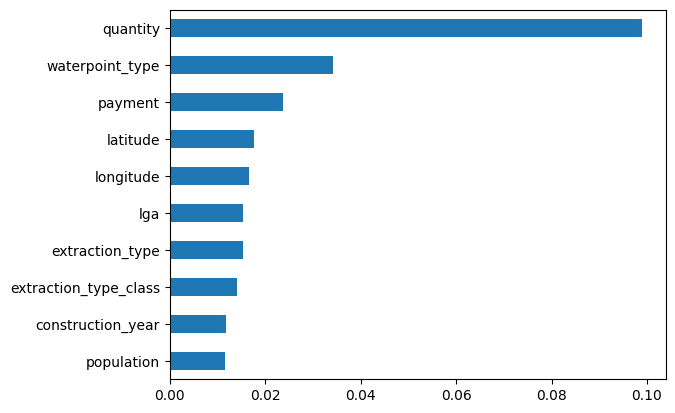

In [ ]:
# plotting top 10 features
df_perm['imp_mean'].tail(10).plot(kind='barh')

# horizontal bar graph with quantity the longest, followed by waterpoint_type and payment

# we can also look at the most unimportant features - e.g. ones with negative values and the ones close to 0